Found 14461 images belonging to 3 classes.
Found 2892 images belonging to 3 classes.
Found 1929 images belonging to 3 classes.
Tên các lớp: ['0_normal', '1_covid19', '2_Pneumonia']
Class Weights: {0: 0.956795024480614, 1: 0.95584638773217, 2: 1.1005327245053274}
Epoch 1/100
452/452 [==============================] - ETA: 0s - loss: 0.7574 - accuracy: 0.6928
Epoch 1: val_accuracy improved from -inf to 0.70885, saving model to E:/lv/ResNet50\best_model.h5
452/452 [==============================] - 123s 262ms/step - loss: 0.7574 - accuracy: 0.6928 - val_loss: 0.7885 - val_accuracy: 0.7089 - lr: 0.0100
Epoch 2/100
452/452 [==============================] - ETA: 0s - loss: 0.7061 - accuracy: 0.7199
Epoch 2: val_accuracy improved from 0.70885 to 0.73790, saving model to E:/lv/ResNet50\best_model.h5
452/452 [==============================] - 109s 242ms/step - loss: 0.7061 - accuracy: 0.7199 - val_loss: 0.6481 - val_accuracy: 0.7379 - lr: 0.0100
Epoch 3/100
452/452 [===========================

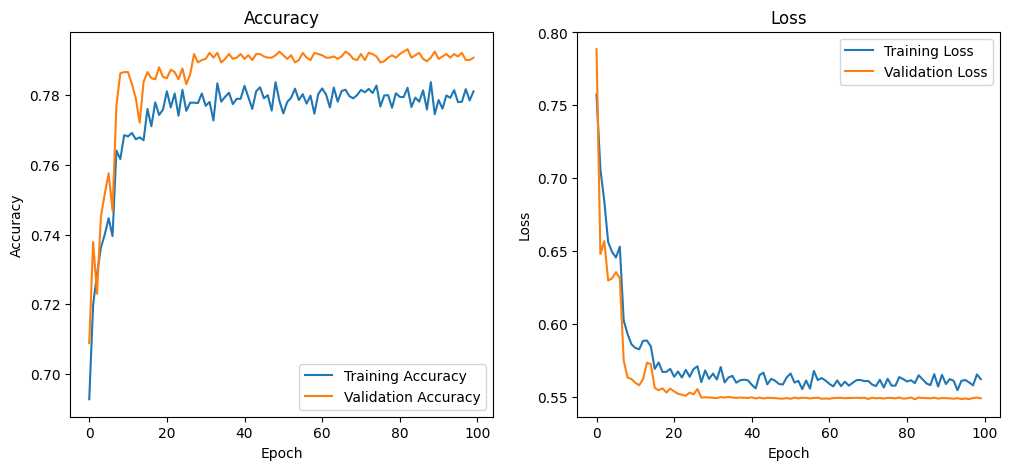

61/61 [==============================] - 13s 220ms/step - loss: 0.5430 - accuracy: 0.7973
Test Accuracy: 0.80
Test Loss: 0.54
61/61 [==============================] - 13s 197ms/step


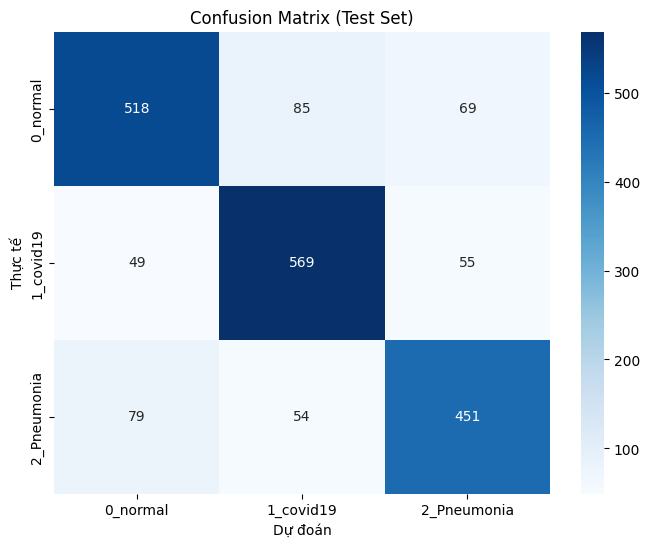

Classification Report (Test Set):
              precision    recall  f1-score   support

    0_normal       0.80      0.77      0.79       672
   1_covid19       0.80      0.85      0.82       673
 2_Pneumonia       0.78      0.77      0.78       584

    accuracy                           0.80      1929
   macro avg       0.80      0.80      0.80      1929
weighted avg       0.80      0.80      0.80      1929



In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.applications import ResNet50
from tensorflow import keras
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau


IMAGE_LEN = 224
IMAGE_SIZE = (IMAGE_LEN, IMAGE_LEN)
BATCH_SIZE = 8
NUM_CLASSES = 3  

# Sử dụng ImageDataGenerator để tăng cường dữ liệu
train_datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.1,                
    horizontal_flip=True,          
    rotation_range=5               

)

val_test_datagen = ImageDataGenerator(
    rescale=1./255
)

# Load dữ liệu train
train_dataset = train_datagen.flow_from_directory(
    'D:/x-ray_split/train',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=1
)

# Load dữ liệu validation
val_dataset = val_test_datagen.flow_from_directory(
    'D:/x-ray_split/val',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=1,
    shuffle=False
)

# Load dữ liệu test
test_dataset = val_test_datagen.flow_from_directory(
    'D:/x-ray_split/test',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=1,
    shuffle=False  
)

# Lấy tên các lớp
class_names = list(train_dataset.class_indices.keys())
print("Tên các lớp:", class_names)

# Cân bằng dữ liệu 
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_dataset.classes),
    y=train_dataset.classes
)

class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

# Xây dựng mô hình với ResNet50
def build_model(num_classes):
    inputs = keras.Input(shape=(IMAGE_LEN, IMAGE_LEN, 3))

    base_model = ResNet50(include_top=False, input_tensor=inputs, weights='imagenet')
    base_model.trainable = False 

    # Global Average Pooling và các lớp cuối cùng
    x = tf.keras.layers.GlobalAveragePooling2D(name='avg_pool')(base_model.output)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.1, name='top_dropout')(x)
    outputs = keras.layers.Dense(num_classes, activation='softmax', name='pred')(x)

    model = tf.keras.Model(inputs, outputs, name='resnet-50')

    
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

model = build_model(NUM_CLASSES)

checkpoint = ModelCheckpoint(
    filepath='E:/lv/ResNet50/best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)


lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=3, 
    min_lr=1e-6,
    verbose=1
)
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=100,
    callbacks=[checkpoint, lr_scheduler],
    verbose=1,
    class_weight=class_weights  # Trọng số lớp để cân bằng dữ liệu
)


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Đánh giá mô hình trên tập test
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f'Test Accuracy: {test_accuracy:.2f}')
print(f'Test Loss: {test_loss:.2f}')

# Ma trận nhầm lẫn trên tập test
true_labels = test_dataset.classes
predictions = model.predict(test_dataset)
predicted_labels = np.argmax(predictions, axis=1)
conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Test Set)')
plt.ylabel('Thực tế')
plt.xlabel('Dự đoán')
plt.show()

# Báo cáo phân loại chi tiết
print("Classification Report (Test Set):")
print(classification_report(true_labels, predicted_labels, target_names=class_names))

model.save('E:/lv/ResNet50/last_model_100e.h5')

Found 1929 images belonging to 3 classes.
242/242 [==============================] - 18s 63ms/step - loss: 0.5430 - accuracy: 0.7973
Test Accuracy: 0.7973
Test Loss: 0.5430
242/242 [==============================] - 15s 60ms/step


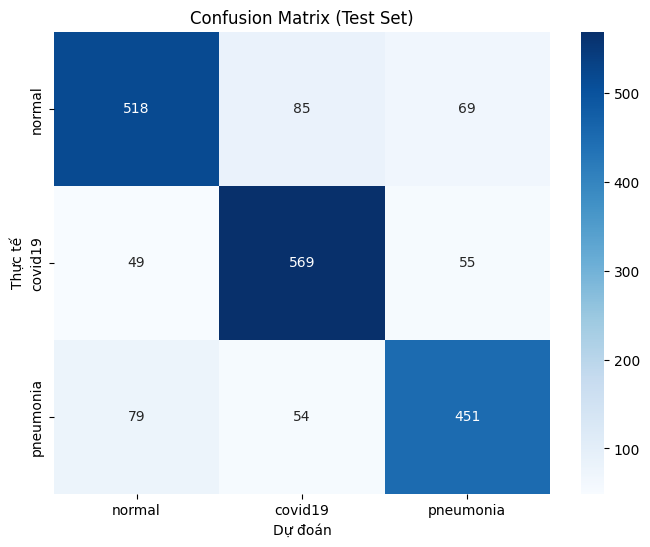

Classification Report (Test Set):
              precision    recall  f1-score   support

      normal     0.8019    0.7708    0.7860       672
     covid19     0.8037    0.8455    0.8240       673
   pneumonia     0.7843    0.7723    0.7783       584

    accuracy                         0.7973      1929
   macro avg     0.7966    0.7962    0.7961      1929
weighted avg     0.7972    0.7973    0.7969      1929



In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Định nghĩa các tham số
IMAGE_LEN = 224
IMAGE_SIZE = (IMAGE_LEN, IMAGE_LEN)
BATCH_SIZE = 8
class_names = ['normal', 'covid19', 'pneumonia'] 

# Sử dụng ImageDataGenerator để tải lại tập test
val_test_datagen = ImageDataGenerator(rescale=1./255)


test_dataset = val_test_datagen.flow_from_directory(
    'D:/x-ray_split/test',  
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

model = load_model('E:/lv/resnet50/last_model_100e.h5')

# Đánh giá mô hình trên tập test và hiển thị với 4 chữ số thập phân
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test Loss: {test_loss:.4f}')

# Dự đoán nhãn trên tập test
true_labels = test_dataset.classes
predictions = model.predict(test_dataset)
predicted_labels = np.argmax(predictions, axis=1)

# Ma trận nhầm lẫn trên tập test
conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Test Set)')
plt.ylabel('Thực tế')
plt.xlabel('Dự đoán')
plt.show()


print("Classification Report (Test Set):")
print(classification_report(true_labels, predicted_labels, target_names=class_names, digits=4))
